# Notebook on Region Graphs and Sum Product Layers


# Goals
By the end of this tutorial you will:

* [know what a region graph is](#What-is-a-Region-Graph?)
* know how to [choose between region graphs](#Choosing-Region-Graphs) for your circuit
* understand how to parametrize a circuit by [choosing a sum product layer](#Choosing-a-Sum-Product-Layer)
* build circuits to **tractably** estimate a [probability distribution over images](#Experiments)[<sup>1</sup>](#fn1)

We say that such circuits are tractable in the sense that the circuits allow us to compute exact likelihoods and marginal/conditional likelihoods.



# How to build your circuit

In order to build a circuit, we need two main ingredients:

1. A **region graph**
2. A **parameterization**


## Why do we need these ingredients?

We need these ingredients because we want to build **tractable/efficient** models that are **expressive**.

### 1. [Region Graph](#Regions-Graphs:-High-Level)

The structure of the region graph is what determines if inference is tractable or not. Cirkit makes it easy for you to use the following region graphs:

* random-binary-tree
* quad-graph
* quad-tree-2
* quad-tree-4
* poon-domingos

Depending on your data, some of these region graphs will be a better choice than others. E.g. for images, quad-tree and quad-graph are more appropriate, as we will see.

### 2. [Parameterization](#Parameterization)

  
#### Choice of sum product layers
Given the **region graph**, we have specified the hierarchical relationship between the random variables, but we have not yet defined the computational graph needed to compute output distribution. To do so, we need to define the structure of products and sum layers. These come in three flavours in cirkit:
* $CP$
* $CP^T$
* Tucker

#### Choice of Overparameterization

The goal of overparametrization is to make the circuit more expressive, i.e. to improve how well it can fit a given distribution, while keeping the circuit tractable.

Given a region graph and a choice of sum product layer, the simplest way to build a circuit is to associate a single input distribution unit per leaf
region, a single sum per inner region, and a single product unit per partition, and then connect them
following the RG structure. We can adapt this strategy to the *deep learning recipe*, and output instead an **overparameterized**
circuit. With overparameterization we refer to the process of “populating”
a RG with not one but many sum, product and input units of the same scope.

The learnable parameters of a circuit exist in two places:
* Input layers (e.g. two parameters ($\mu$, $\sigma$) for a univariate Gaussian and a parameter per class for a Categorical input)
* Sum layers (one parameter per input to the sum layer)

Given the region graph and choice of sum product layer, the simplest circuit we can define parameterizes a single input distribution per leaf node of the region graph and has a single sum unit per input to the sum layer.
However, we can follow the deep learning recipe increase the expressivity of the circuit by overparameterizing it.
We do so by:

* Parameterizing multiple copies of the input distribution per leaf node
* Parameterizing multiple sum units per input to the sum layer

For example, in the notebook we will use:

```
NUM_INPUT_UNITS = 64   # we use 64 input distributions per leaf node
NUM_SUM_UNITS = 64     # we use 64 sum units per input to the sum layer
```

[<sup id="fn1">1</sup>](#fn1-back)  This is intractable for general neural network models.



# Data Setup

As with the [previous tutorial](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb), we will be working on the MNIST Dataset, so we begin by loading that:

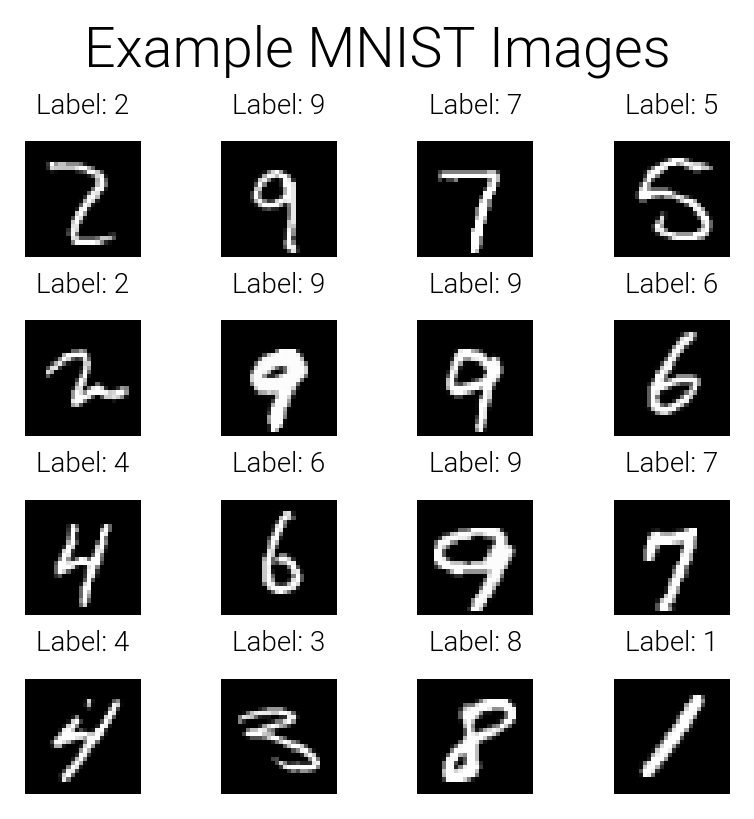

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

PIXEL_RANGE=255
# Store an example image
example_image = None

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (PIXEL_RANGE * x).long())
])

# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    images, labels = next(iter(dataloader))
    
    example_image = images[0]
    images = images[:gridsize**2]
    
    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))
    
    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
    # Adjust spacing between subplots
    fig.suptitle('Example MNIST Images')
    plt.tight_layout()
    plt.show()


data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Call the function to plot images
plot_sample_images(train_dataloader, gridsize=4)

# Regions Graphs: High Level




## What is a Region Graph?


<div style="width: 20%; float: right;">

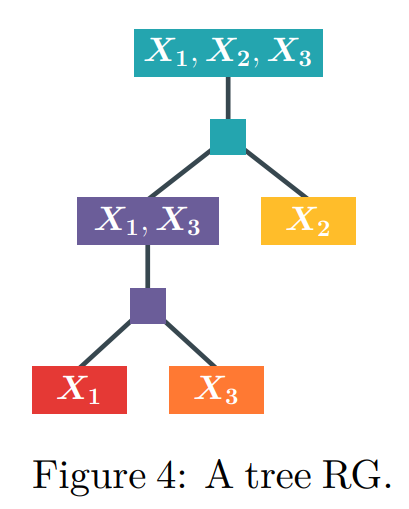

</div>

<div style="width: 80%;">

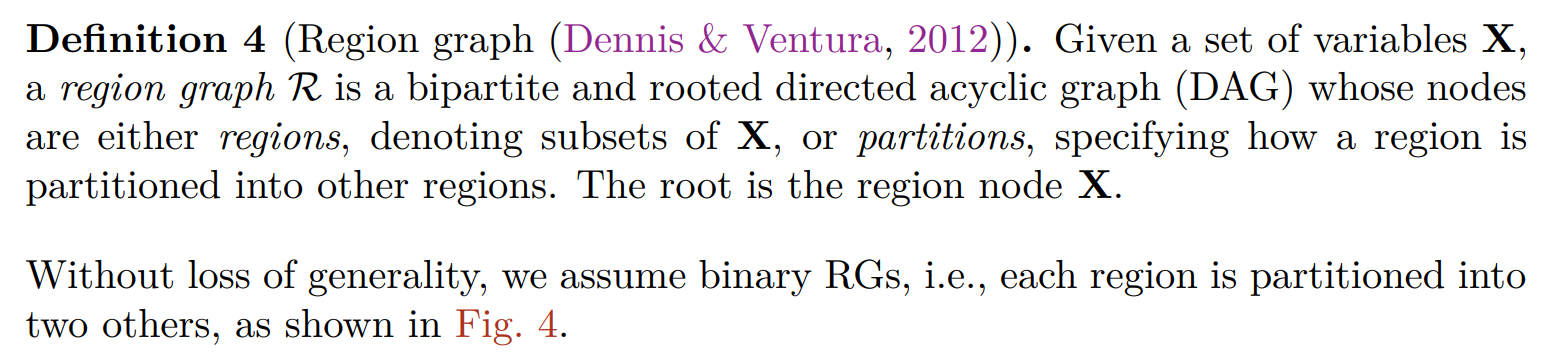

</div>

E.g. for the example on the right we have the root node (region) $\mathbf{X} = X_1, X_2, X_3$.
Below the root is a partition node, that splits the join region into two regions: $X_1, X_3$ and $X_2$.

## Images
In our example, each random variable, $X_i$, represents a single pixel in the image.
If we think of the region graph in a top down fashion, the region graph is splitting the image into subsets of pixels.
If those subsets of pixels are contiguous in the image, we can think of the region graph as splitting the image into patches, as we illustrate on the right.

<div style="max-width:20%; float: right;">

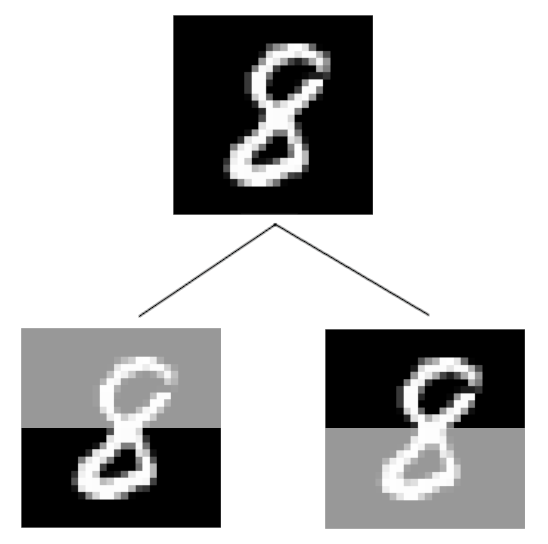

</div>

## Modelling Pixels with Random Variables
More specifically, we assign each pixel a **categorical random variable** with 256 output classes (i.e. one for each possible grayscale pixel value).


## Specifying Region Graphs in Cirkit
We begin where we left off in the [previous tutorial](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb).
Recall we used:

```python
from cirkit.templates import circuit_templates

symbolic_circuit = circuit_templates.image_data(
    (1, 28, 28),                # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
    # ----------------------------------------------------------------------------------------------------
    region_graph='quad-graph',  # Select the structure of the circuit to follow the QuadGraph region graph 
    # -----------------------------------------------------------------------------------------------------
    input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
    num_input_units=64,         # Each input layer consists of 64 Categorical input units
    sum_product_layer='cp',     # Use CP sum-product layers, i.e., alternate dense sum layers and hadamard product layers
    num_sum_units=64,           # Each dense sum layer consists of 64 sum units
    sum_weight_param=circuit_templates.Parameterization(
        activation='softmax',   # Parameterize the sum weights by using a softmax activation
        initialization='normal' # Initialize the sum weights by sampling from a standard normal distribution
    )
)
```

The easiest way to specify which region graph to use is by changing the `region_graph` line in the above `image_data` function. For the time being, we will treat the region graph as a hyperparameter - we will explain the details of some region graphs and some considerations for choosing one over another in the [following section](#Region-Graphs:-Deep-Dive).

# Example using the `image_data` API

In our example we used a **Quad Graph** region graph.
The `image_data` API conveniently allows us to specify the region graph as a string.
It can be one of:

* random-binary-tree
* quad-graph
* quad-tree-2
* quad-tree-4
* poon-domingos     `we avoid this for this task as it can be very computationally expensive`

Each such region graph can be used by simply replacing the `region_graph` option via the API:

In [2]:
from cirkit.templates import circuit_templates


def define_circuit(region_graph):
    circuit = circuit_templates.image_data(
        (1, 28, 28),                # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
        # ----------------------------------------------------------------------------------------------------
        region_graph=region_graph,  # Select the structure of the circuit to follow the QuadGraph region graph 
        # -----------------------------------------------------------------------------------------------------
        input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
        num_input_units=64,         # Each input layer consists of 64 Categorical input units
        sum_product_layer='cp',     # Use CP sum-product layers, i.e., alternate dense sum layers and hadamard product layers
        num_sum_units=64,           # Each dense sum layer consists of 64 sum units
        sum_weight_param=circuit_templates.Parameterization(
            activation='softmax',   # Parameterize the sum weights by using a softmax activation
            initialization='normal' # Initialize the sum weights by sampling from a standard normal distribution
        )
    )
    return circuit

circuits = dict()
circuits['quad-graph + cp'] = define_circuit('quad-graph')
# We can change the region graph to Random Binary Tree
circuits['random-binary-tree + cp'] = define_circuit('random-binary-tree')
# Or Quad Tree
circuits['quad-tree-2 + cp'] = define_circuit('quad-tree-2')
circuits['quad-tree-4 + cp'] = define_circuit('quad-tree-4')

Next we take a deeper dive into region graphs.
If you would rather work with circuits using the `image_data` api, you can skip the deep dive and go run the experiments [here](#Experiments).

# Region Graphs: Deep Dive

<div style="font-size: 1.5em;">
    
> RQ1: Consider the task of distribution estimation on image data. What region graph should you use?

</div>

## Choosing Region Graphs

In this notebook we consider the following three choices of region graphs:

* Random Binary Tree
* Quad Tree
* Quad Graph

In [3]:
from cirkit.symbolic.circuit import Circuit
from cirkit.templates.region_graph import RandomBinaryTree, RegionGraph
from cirkit.symbolic.layers import CategoricalLayer
from cirkit.templates.circuit_templates.utils import Parameterization, parameterization_to_factory

NUM_INPUT_UNITS = 64
NUM_SUM_UNITS = 64

def define_circuit_from_rg(rg: RegionGraph, sum_prod_layer: str = 'cp') -> Circuit:
    # Here is where Overparameterization comes in
    input_factory = lambda scope, y, z: CategoricalLayer(
        scope=scope,
        num_categories=PIXEL_RANGE+1,
        num_channels=1, # These are grayscale images
        num_output_units=NUM_INPUT_UNITS # Overparameterization
    )

    # Note that below intialisation is needed
    sum_weight_param = Parameterization(activation='softmax', initialization='normal')
    sum_weight_factory = parameterization_to_factory(sum_weight_param)
    
    circuit = Circuit.from_region_graph(
        rg,
        input_factory=input_factory,
        sum_weight_factory= sum_weight_factory,
        num_sum_units=NUM_SUM_UNITS,
        sum_product=sum_prod_layer
    )
    return circuit

# Random Binary Tree




<div style="width: 50%; float: left; margin-left: 3%;">

The random binary tree is a general and simple choice - we simply hierarchically split the pixels into subsets without taking into account the spatial structure of the image. We illustrate such a binary tree on the right.
Note that the partitions happen to be diagonals. In general, in a large image the subsets of pixels are unlikely to be contiguous.

### Options
For the random binary tree we need to select the `depth`, which we set to `None` to make the depth of the tree as large as possible.
For the random binary tree we can also specify to have more than a single region graph, buy specifying `num_repetitions`, as popularized by the [RAT-SPN paper](https://proceedings.mlr.press/v115/peharz20a). Here we choose a single repetition for simplicity.

The code is as follows.

</div>

<div style="width: 40%; float: right;">
    
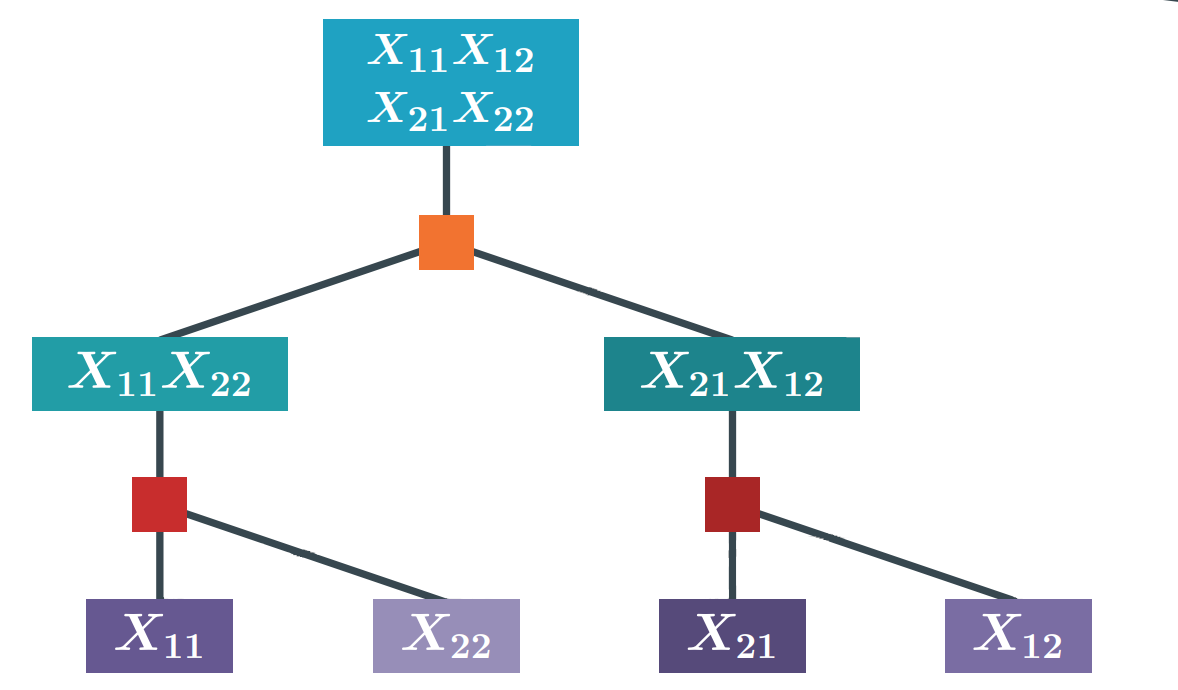

</div>

In [4]:
from cirkit.templates.region_graph import RandomBinaryTree
# Note that the random binary tree works on flat inputs (i.e. vectors)
# We therefore compute the number of random variables needed (one per pixel value)
img_shape = example_image.shape[1:]
n = np.prod(img_shape)

# We can also specify depth and number of repetitions
# depth=None means maximum possible
rnd = RandomBinaryTree(n, depth=None, num_repetitions=1)

circuits = dict()
circuits['random-binary-tree + cp'] = define_circuit_from_rg(rnd)   # cp is the default second argument

# Quad Tree

<div style="width: 50%; float: left; margin-left: 3%;">

While the random binary tree is general and straightforward to create, it ignores the spatial structure present in images: pixels that are close together are likely to be correlated.
What if we partioned the pixels into subsets in a way that creates actual patches of contiguous pixels?

This is what the quad tree and quad graph region graphs do, we illustrate a `quad-tree-2` on the right.
Note the difference with the random binary tree: the partitions are image patches instead of random subsets of pixels.


### Options
Here we use `num_patch_splits`=$2$ to specify that the image is folded into two subsets when split, i.e. the region graph is a binary tree.
It is also possible to choose `num_patch_splits`=$4$ to break each patch into 4 quadrants, i.e. each region in the region graph has $4$ children. For more details see the `num_patch_splits` argument.

</div>

<div style="width: 40%; float: right;">
    
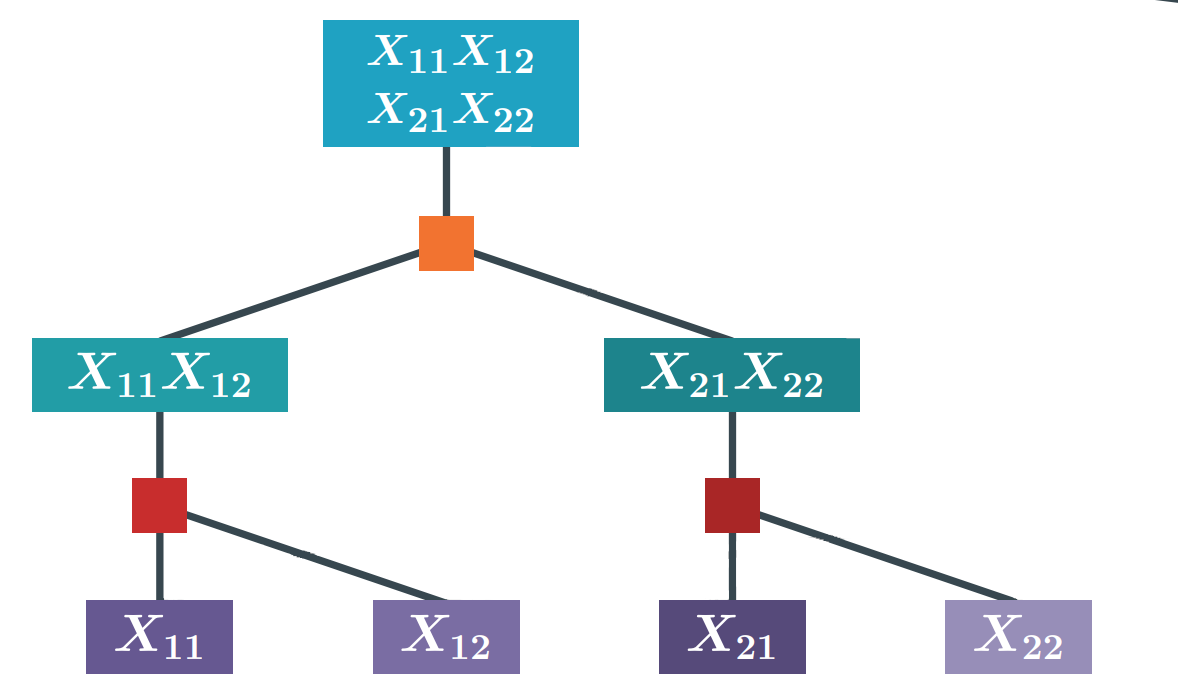

</div>

In [5]:
from cirkit.templates.region_graph import QuadTree

qt = QuadTree(img_shape, num_patch_splits=2)

circuits['quad-tree-2 + cp'] = define_circuit_from_rg(qt)

# Quad Graph

<div style="width: 50%; float: left; margin-left: 3%;">

In contrast to the quad tree, a quad graph is a directed acyclic graph.
This means that it can model more partitions of the random variables than the quad tree (e.g. see plot on the right compared to above).
While this can make the resulting circuit more expressive, it also increases the number of learnable parameters in the circuit, since the quad graph region graph has more regions that the quad tree.

</div>

<div style="width: 40%; float: right;">
    
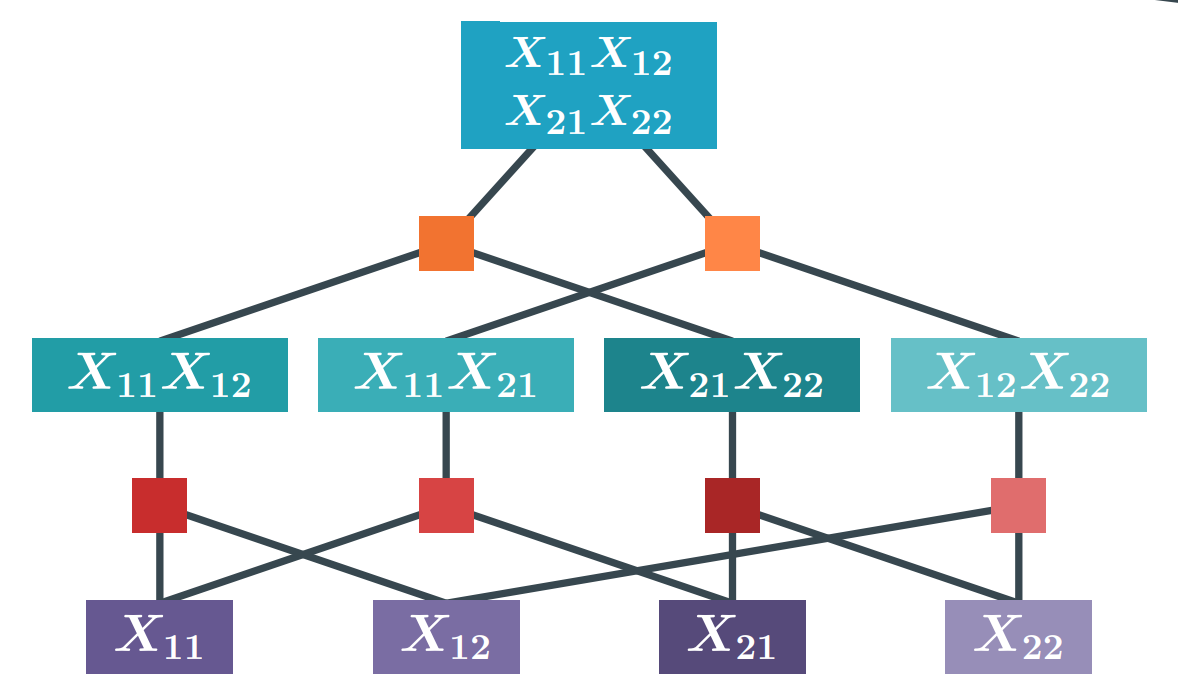

</div>

In [6]:
from cirkit.templates.region_graph import QuadGraph

qg = QuadGraph(img_shape)

circuits['quad-graph + cp'] = define_circuit_from_rg(qg)

# Parameterization

<div style="font-size: 1.5em;">

> RQ2: What is the best sum product layer parameterization for our image distribution estimation task?

</div>

## Choosing a Sum Product Layer

In the previous examples we used `cp` as the sum product layer by default. But what is `cp`? To understand this we first need to introduce the layers that comprise sum product layers.

## Layers

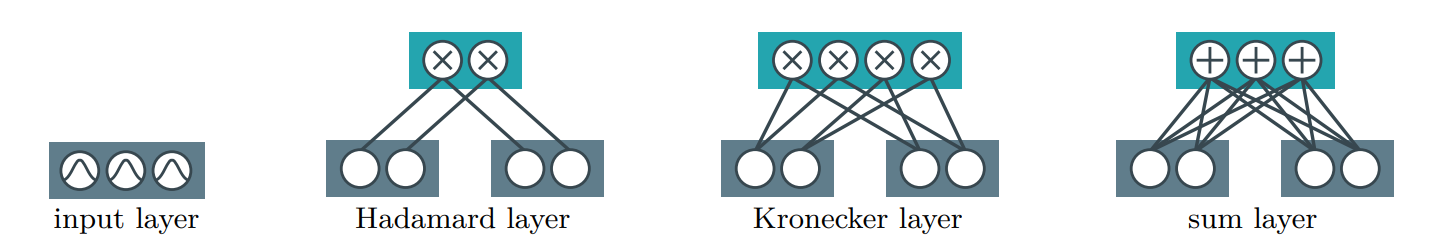

The layers above are fundamental building blocks of circuits.

### Input Layer
Input layers (left) are random variables. In our case, our input layers are Categorical random variables with 256 classes, one per possible pixel value.

### Product Layer
There are two types of product layer (center):
1. Hadamard
2. Kronecker

The inputs to a Hadamard layer must have the same dimension and the computed output is the element-wise product of those inputs.
On the other hand, kronecker takes an outer product. So if the first input has $a$ dimensions and the second has $b$ dimensions, the output has $ab$ dimensions.

### Sum Layer
For sum layer (right), each sum unit weighs an input and computes the sum.


### Learnable Parameters
From the layers above, only the input layers and sum layers admit learnable parameters, which we commonly represent as matrices ($\mathbf{W}, \mathbf{Q}$).
However, note that the choice of product layer affects the number of inputs to sum layers, so can therefore affect the number of learnable parameters in a circuit.

## Layer Representations

Sum product layers are made by combining a product layer with a sum layer from above.
To easily see the combinations, we represent each layer with the following representations.
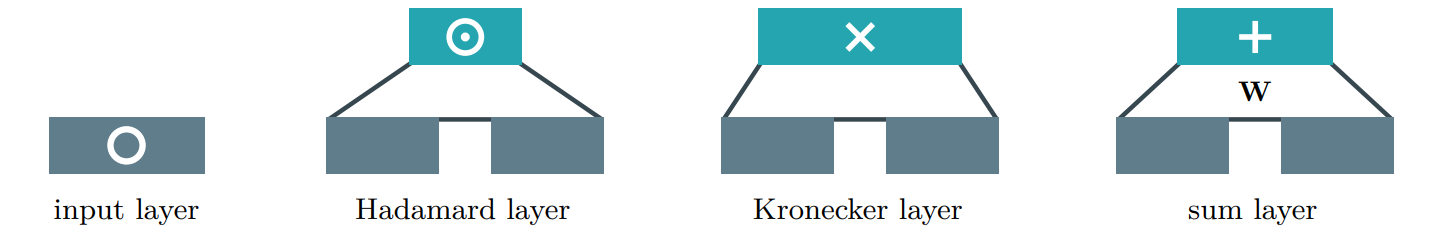

## Sum Product Layers

Below, we show a diagram of each sum product layer by using the representations introduced above.

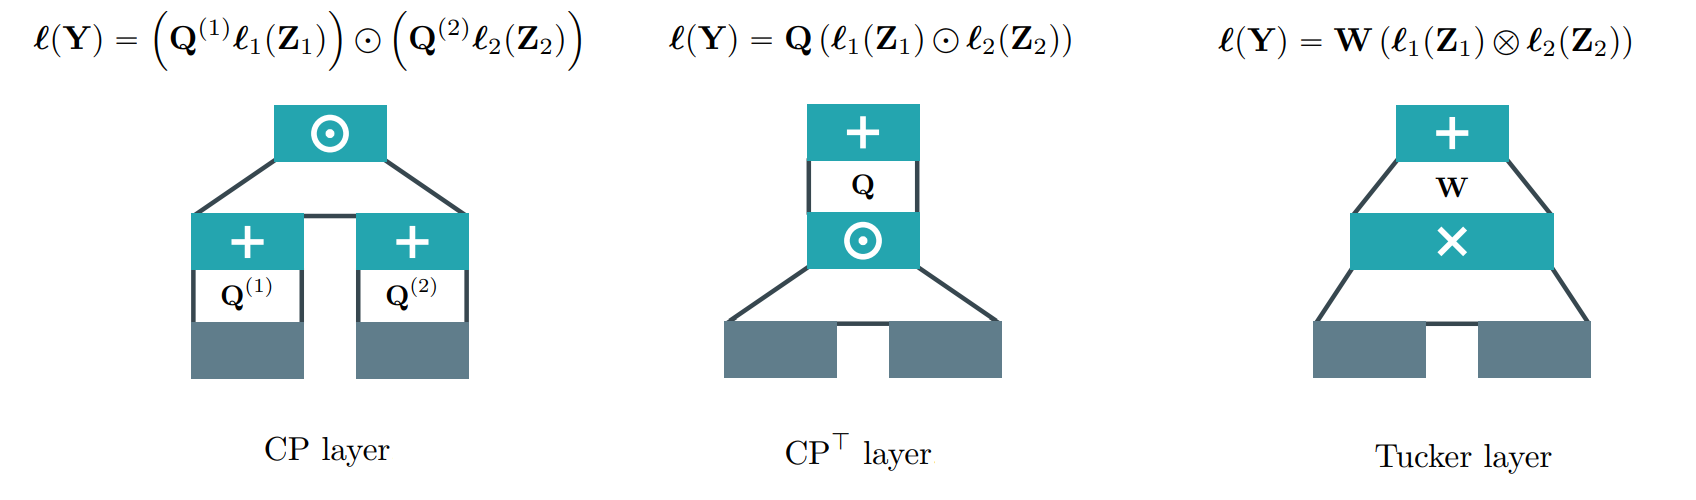

We can now show how the sum product layers are constructed from their parts. At the top of the figure we show an equation describing the layer, where $l_i$ are the sub-circuits that feed into our sum product layer, $\mathbf{Z}$ are inputs to the sub-circuits, and $\mathbf{Q}$ and $\mathbf{W}$ are matrices of parameters for the sum layers.

Now that we have introduced `cp.T` and `tucker`, we construct versions of our circuits with these sum product layers, in order to compare the effect of the parameterization on the results in the experiments we will run next.

In [7]:
circuits['random-binary-tree + cp.T'] = define_circuit_from_rg(rnd, 'cp-t')
circuits['random-binary-tree + Tucker'] = define_circuit_from_rg(rnd, 'tucker')

circuits['quad-tree-2 + cp.T'] = define_circuit_from_rg(qt, 'cp-t')
circuits['quad-tree-2 + Tucker'] = define_circuit_from_rg(qt, 'tucker')

circuits['quad-graph + cp.T'] = define_circuit_from_rg(qg, 'cp-t')
circuits['quad-graph + Tucker'] = define_circuit_from_rg(qg, 'tucker')

# Experiments
We now compare results on distribution estimation for the region graphs and sum product layers we have introduced.

In [8]:
import random
import torch
import numpy as np
import pandas as pd


from cirkit.pipeline import compile


def train_and_eval_circuit(cc):

    # Set some seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    # torch.cuda.manual_seed(42)
    
    # Set the torch device to use
    device = torch.device('cuda')

    # Compile the circuit
    circuit = compile(cc)
    
    # Move the circuit to chosen device
    circuit = circuit.to(device)
    
    num_epochs = 5
    step_idx = 0
    running_loss = 0.0
    stats = dict()

    stats['# trainable parameters'] = sum(p.numel() for p in circuit.parameters())
    stats['train loss'] = []
    
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(circuit.parameters(), lr=0.01)
    
    for epoch_idx in range(num_epochs):
        for i, (batch, _) in enumerate(train_dataloader):
            # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
            # so we unsqueeze a dimension for the channel.
            BS = batch.shape[0]
            batch = batch.view(BS, 1, -1).to(device)
    
            # Compute the log-likelihoods of the batch, by evaluating the circuit
            log_likelihoods = circuit(batch)
    
            # We take the negated average log-likelihood as loss
            loss = -torch.mean(log_likelihoods)
            loss.backward()
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.detach() * len(batch)
            step_idx += 1
            if step_idx % 100 == 0:
                average_nll = running_loss / (100 * len(batch))
                print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
                running_loss = 0.0
                
                stats['train loss'].append(average_nll.cpu().item())

    with torch.no_grad():
        test_lls = 0.0
    
        for batch, _ in test_dataloader:
            # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
            # so we unsqueeze a dimension for the channel.
            BS = batch.shape[0]
            batch = batch.view(BS, 1, -1).to(device)
    
            # Compute the log-likelihoods of the batch
            log_likelihoods = circuit(batch)
    
            # Accumulate the log-likelihoods
            test_lls += log_likelihoods.sum().item()
    
        # Compute average test log-likelihood and bits per dimension
        average_nll = - test_lls / len(data_test)
        bpd = average_nll / (28 * 28 * np.log(2.0))
        print(f"Average test LL: {average_nll:.3f}")
        print(f"Bits per dimension: {bpd:.3f}")
        
        stats['test loss'] = average_nll
        stats['test bits per dimension'] = bpd

    # Free GPU memory
    circuit = circuit.to('cpu')
    torch.cuda.empty_cache()

    stats['train loss (min)'] = min(stats['train loss'])
    return stats


results = dict()
for k, cc in circuits.items():
    print('\nTraining circuit with region graph "%s"' % k)
    
    results[k] = train_and_eval_circuit(cc)
    results[k]['sum product layer'] = k.split('+')[1]


Training circuit with region graph "random-binary-tree + cp"
Step 100: Average NLL: 3422.423
Step 200: Average NLL: 1614.733
Step 300: Average NLL: 1013.035
Step 400: Average NLL: 954.595
Step 500: Average NLL: 930.759
Step 600: Average NLL: 928.207
Step 700: Average NLL: 924.093
Step 800: Average NLL: 916.476
Step 900: Average NLL: 919.580
Step 1000: Average NLL: 911.700
Step 1100: Average NLL: 916.981
Average test LL: 914.781
Bits per dimension: 1.683

Training circuit with region graph "quad-tree-2 + cp"
Step 100: Average NLL: 3423.503
Step 200: Average NLL: 1599.988
Step 300: Average NLL: 951.543
Step 400: Average NLL: 851.868
Step 500: Average NLL: 802.758
Step 600: Average NLL: 779.314
Step 700: Average NLL: 761.668
Step 800: Average NLL: 743.466
Step 900: Average NLL: 737.404
Step 1000: Average NLL: 723.257
Step 1100: Average NLL: 722.298
Average test LL: 714.139
Bits per dimension: 1.314

Training circuit with region graph "quad-graph + cp"
Step 100: Average NLL: 3413.503
Step

In [9]:
# Print results
df = pd.DataFrame.from_dict(results, orient='index')
df = df.drop(columns='train loss')

df.index = df.index.map(lambda x: x.split('+')[0])
df["# trainable parameters"] = df["# trainable parameters"].map('{:,d}'.format)
pd.options.display.float_format = "{:,.3f}".format

df.sort_values('test bits per dimension')

,# trainable parameters,test loss,test bits per dimension,train loss (min),sum product layer
quad-graph,"25,641,474",711.308,1.309,718.698,cp
quad-graph,"421,306,626",713.140,1.312,720.701,Tucker
quad-tree-2,"19,251,328",714.139,1.314,722.298,cp
quad-graph,"19,259,778",717.598,1.321,719.495,cp.T
quad-tree-2,"217,845,760",720.130,1.325,728.526,Tucker
quad-tree-2,"16,048,192",724.648,1.333,726.819,cp.T
random-binary-tree,"217,845,760",903.237,1.662,904.251,Tucker
random-binary-tree,"19,251,328",914.781,1.683,911.700,cp
random-binary-tree,"16,048,192",916.002,1.686,912.927,cp.T


# Results

In the results above we have ordered the models based on the resulting `test bits per dimension` where the lower the number is the better our model is at distribution estimation.

**[RQ1](#Region-Graphs:-Deep-Dive)**: As can be seen, quad-graph and quad-tree are better suited for modelling image data; they have superior generalisation as measured in `bits per dimension` when compared to random-binary-tree for all sum product layers.

**[RQ2](#Parametrization)**: We see that for quad-tree and quad-graph, CP and CP.T give us the best results for our task, especially when taking into account how many more trainable parameters `tucker` requires. However, `tucker` does give us better results when we use a random-binary-tree region graph.

# Further reading

For more details on region graphs, parameterizations and folding, see Chapters 4 and 5 of [What is the Relationship between Tensor Factorizations
and Circuits ](https://arxiv.org/abs/2409.07953).
For the implementations, see the code for the supported [Region Graphs](https://github.com/april-tools/cirkit/blob/main/cirkit/templates/region_graph/algorithms). More specifically, if you are interested in building region-graphs that capture the structure of your dataset, you may want to check out [Chow-Liu Trees](https://github.com/april-tools/cirkit/blob/main/cirkit/templates/region_graph/algorithms/chow_liu.py).

Another important choice has to do with optimising the circuit via folding, learn more in the notebook on [compilation](https://github.com/april-tools/cirkit/blob/main/notebooks/compilation-options.ipynb).